In [1]:
import pandas as pd
import numpy as np
# load library
import matplotlib.pyplot as plt

from dateutil.parser import parse

# this is a 'magic word' that allows for plots to be displayed
# inline with the notebook. If you want to know more, see:
# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline

In [2]:

hubway_stations_df = pd.read_csv('hubway_stations.csv', sep=',').sort_values(['station'], ascending=True)
hubway_trips_df = pd.read_csv('hubway_trips.csv', sep=',')
weather_df = pd.read_csv('weather.csv', sep=',')


In [331]:
weather_boston = pd.read_csv('boston_weather.csv', sep=',')

In [340]:
weather_boston.dtypes

Year                           int64
Month                          int64
Day                            int64
High Temp (F)                  int64
Avg Temp (F)                   int64
Low Temp (F)                   int64
High Dew Point (F)             int64
Avg Dew Point (F)              int64
Low Dew Point (F)              int64
High Humidity (%)              int64
Avg Humidity (%)               int64
Low Humidity (%)               int64
High Sea Level Press (in)    float64
Avg Sea Level Press (in)     float64
Low Sea Level Press (in)     float64
High Visibility (mi)           int64
Avg Visibility (mi)            int64
Low Visibility (mi)            int64
High Wind (mph)                int64
Avg Wind (mph)                 int64
High Wind Gust (mph)           int64
Snowfall (in)                float64
Precip (in)                  float64
Events                        object
dtype: object

In [333]:
same_counts = weather_boston[['Year', 'Month']].groupby(by=['Year']).count().reset_index().sort_values(['Year'], ascending=True)

,Year,Month
0,2008,366
1,2009,365
2,2010,365
3,2011,365
4,2012,366
5,2013,365
6,2014,365
7,2015,365
8,2016,366
9,2017,365


In [341]:
x_counts = weather_boston[['Events', 'Year']].groupby(by=['Events']).count().reset_index().sort_values(['Events'], ascending=True)

In [342]:
x_counts

,Events,Year
0,Both,148
1,None,2108
2,Rain,1259
3,Snow,234


In [3]:
hubway_trips_df['start_date'] = hubway_trips_df['start_date'].apply(lambda x: parse(x))
hubway_trips_df['year_start'] = hubway_trips_df['start_date'].apply(lambda x: x.year)
hubway_trips_df['month_start'] = hubway_trips_df['start_date'].apply(lambda x: x.month)
hubway_trips_df['weekday_start'] = hubway_trips_df['start_date'].apply(lambda x: x.dayofweek)
hubway_trips_df['day_start'] = hubway_trips_df['start_date'].apply(lambda x: x.day)
hubway_trips_df['hour_start'] = hubway_trips_df['start_date'].apply(lambda x: x.hour)

hubway_trips_df = hubway_trips_df.rename(columns={'status': 'trip_status'})


In [155]:
hubway_trips_df['weekday_start'] = hubway_trips_df['start_date'].apply(lambda x: x.dayofweek)

In [264]:
weather_counts = weather_df[['STATION_NAME', 'STATION']].groupby(by=['STATION_NAME']).count().reset_index()
weather_df['year_w'] = weather_df['DATE'].apply(lambda x: int(x[0:4]))
weather_df['month_w'] = weather_df['DATE'].apply(lambda x: int(x[4:6]))
weather_df['day_w'] = weather_df['DATE'].apply(lambda x: int(x[6:8]))
weather_df['hour_w'] = weather_df['DATE'].apply(lambda x: int(x[9:11]))
weather_df['municipal_w'] = 'Boston'
weather_df['w_id'] = weather_df['year_w'].map(str) + '.' + weather_df['month_w'].map(str) + '.' + weather_df['day_w'].map(str)
weather_df = weather_df[['w_id', 'STATION_NAME', 'STATION', 'year_w', 'month_w', 'day_w', 'HPCP']].groupby(by=['w_id', 'STATION_NAME', 'STATION', 'year_w', 'month_w', 'day_w']).mean().reset_index()


In [265]:
master_df = pd.merge(hubway_trips_df, hubway_stations_df, how='left', left_on='strt_statn', right_on='id')
master_df = master_df.rename(columns={'id': 'id_start', 'terminal': 'terminal_start', 'station': 'station_start', 'municipal': 'municipal_start', 'lat': 'lat_start', 'lng': 'lng_start', 'status': 'status_start'})
master_df = pd.merge(master_df, hubway_stations_df, how='left', left_on='end_statn', right_on='id')
master_df = master_df.rename(columns={'id': 'id_end', 'terminal': 'terminal_end', 'station': 'station_end', 'municipal': 'municipal_end', 'lat': 'lat_end', 'lng': 'lng_end', 'status': 'status_end'})
master_df['t_id'] = master_df['year_start'].map(str) + '.' + master_df['month_start'].map(str) + '.' + master_df['day_start'].map(str)
master_df = pd.merge(master_df, weather_df, how='left', left_on=['t_id'], right_on=['w_id' ])
master_df['same_st_flg'] = np.where(master_df['strt_statn'] == master_df['end_statn'], 1, 0)


In [476]:
master_df['age'] = master_df[(master_df['subsc_type']=='Registered') ]['year_start'] - master_df[(master_df['subsc_type']=='Registered') ]['birth_date']
 
       

In [474]:
master_df['age'] 

0          35.0
1          45.0
2          68.0
3          30.0
4          28.0
           ... 
1579020     NaN
1579021     NaN
1579022     NaN
1579023     NaN
1579024     NaN
Name: age, Length: 1579025, dtype: float64

In [336]:
master_df = pd.merge(master_df, weather_boston, how='left', left_on=['year_start', 'month_start', 'day_start'], right_on=['Year', 'Month', 'Day'])

In [266]:
ratio_missing_weather = (master_df['w_id'].isnull().sum() / master_df['w_id'].isnull().count())*100
print("Share of available weather information: ", 100-ratio_missing_weather)

Share of available weather information:  30.08185430882982


In [338]:
ratio_missing_weather = (master_df['Events'].isnull().sum() / master_df['Events'].isnull().count())*100
print("Share of available Boston weather information: ", 100-ratio_missing_weather)

Share of available Boston weather information:  100.0


In [7]:
same_st_flg_counts = master_df[['same_st_flg', 'seq_id']].groupby(by=['same_st_flg']).count().reset_index().sort_values(['seq_id'], ascending=False)
same_st_flg_ratio = same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 1].iloc[0]/same_st_flg_counts['seq_id'][same_st_flg_counts['same_st_flg'] == 0].iloc[0]


In [8]:
print("Share of bike rides that start and finish at the same station: ", same_st_flg_ratio)

Share of bike rides that start and finish at the same station:  0.05078211822076589


In [9]:
stat_interactions = master_df[['municipal_start', 'municipal_end', 'strt_statn', 'end_statn', "duration", 'seq_id']].groupby(by=['municipal_start', 'municipal_end', 'strt_statn', 'end_statn']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(20)
mun_interactions  = master_df[['municipal_start', 'municipal_end', "duration", 'seq_id']].groupby(by=['municipal_start', 'municipal_end']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).sort_values(["use_cnt"], ascending = (False)).reset_index()


In [10]:
stat_interactions

,municipal_start,municipal_end,strt_statn,end_statn,use_cnt,duration_avg
0,Boston,Cambridge,53.0,67.0,5185,301.103182
1,Cambridge,Boston,67.0,53.0,4993,301.273583
2,Boston,Boston,40.0,22.0,4384,656.743841
3,Boston,Boston,22.0,40.0,4208,574.153279
4,Boston,Boston,58.0,58.0,3126,3050.806462
5,Boston,Boston,22.0,43.0,3067,446.979785
6,Boston,Boston,36.0,36.0,2785,4226.570557
7,Boston,Cambridge,33.0,67.0,2751,510.738277
8,Boston,Boston,20.0,22.0,2719,587.488415
9,Boston,Boston,42.0,22.0,2716,699.326951


In [11]:
mun_interactions

,municipal_start,municipal_end,use_cnt,duration_avg
0,Boston,Boston,1089760,1223.099359
1,Cambridge,Cambridge,162901,778.202841
2,Boston,Cambridge,111176,1106.119477
3,Cambridge,Boston,110255,1118.905011
4,Cambridge,Somerville,21037,841.119314
5,Somerville,Cambridge,20786,788.083037
6,Boston,Brookline,14894,1210.676648
7,Brookline,Boston,14590,1013.659287
8,Somerville,Somerville,12827,889.641304
9,Boston,Somerville,6092,1638.786770


In [51]:
municipal_start_counts = master_df[['municipal_start', 'seq_id']].groupby(by=['municipal_start']).agg(use_cnt=('seq_id', 'count')).sort_values(['use_cnt'], ascending=False).reset_index()

In [55]:
municipal_start_counts=municipal_start_counts.join(municipal_start_counts[['use_cnt']].apply(lambda x:100 * x / float(x.sum())).rename(columns={'use_cnt': 'use_pct'}))

In [56]:
municipal_start_counts

,municipal_start,use_cnt,use_pct
0,Boston,1221956,77.387428
1,Cambridge,296778,18.795183
2,Somerville,39674,2.512585
3,Brookline,20603,1.304804


In [37]:
municipal_end_counts = master_df[['municipal_end', 'seq_id']].groupby(by=['municipal_end']).count().reset_index() \
                             .sort_values(['seq_id'], ascending=False)

In [38]:
municipal_end_counts

,municipal_end,seq_id
0,Boston,1220527
2,Cambridge,297606
3,Somerville,40064
1,Brookline,20783


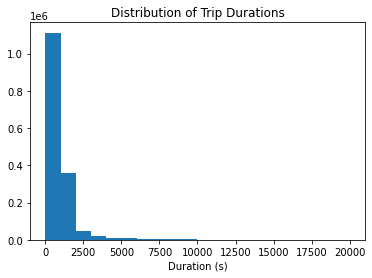

In [616]:
# Plot the histogram of trip durations for each city
plt.hist(master_df['duration'],range = (0, 20000), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [145]:
def plotUserSharePerMunicipality(master_df):
    
    subsc_type_counts = master_df.groupby(['municipal_start', 'subsc_type']).agg(use_cnt=('seq_id', 'count'))
    subsc_type_pcts = subsc_type_counts.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).reset_index().rename(columns={'use_cnt': 'use_pct'})
    labels = ['Boston', 'Brookline', 'Cambridge', 'Somerville']
    reg_pct = subsc_type_pcts[(subsc_type_pcts['subsc_type']=='Registered')]['use_pct']
    cas_pct = subsc_type_pcts[(subsc_type_pcts['subsc_type']=='Casual')]['use_pct']
    width = 0.8 # the width of the bars: can also be len(x) sequence

    fig, ax = plt.subplots()

    ax.bar(labels, reg_pct, width, label='Registered')
    ax.bar(labels, cas_pct, width, bottom=reg_pct,
           label='Casual')

    ax.set_ylabel('Percentage Ratio')
    ax.set_title('Share of Registered vs Casual Users Across Municipalities')
    ax.legend()

    plt.show()


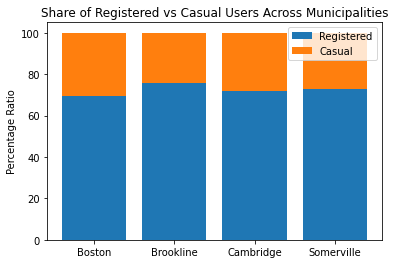

In [146]:
plotUserSharePerMunicipality(master_df)

In [221]:
def plotUserDataPerMonth(master_df, variable, label):
        month_use_counts = master_df[['month_start', 'subsc_type', 'seq_id', 'duration']].groupby(by=['month_start', 'subsc_type']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values(['month_start', 'subsc_type'], ascending=(True, True))
        labels = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered')][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Casual')][variable]
        
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Registered')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Casual')

        ax.set_ylabel(label)
        ax.set_title('Monthly Share of Registered vs Casual Users')
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

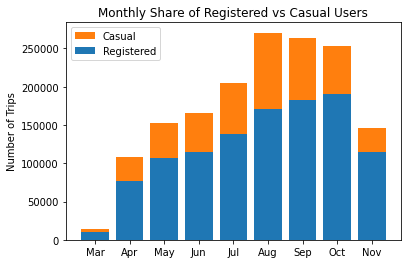

In [222]:
plotUserDataPerMonth(master_df, 'use_cnt', 'Number of Trips') 

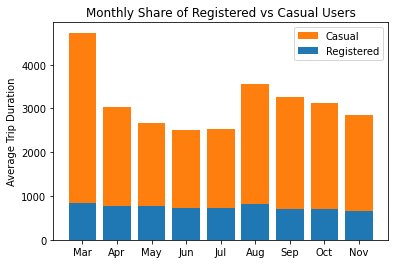

In [223]:
plotUserDataPerMonth(master_df, 'duration_avg', 'Average Trip Duration')

In [224]:
def plotUserDataPerWeekDay(master_df, variable, label):
        month_use_counts = master_df[['weekday_start', 'subsc_type', 'seq_id', 'duration']].groupby(by=['weekday_start', 'subsc_type']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values(['weekday_start', 'subsc_type'], ascending=(True, True))
        labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered')][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Casual')][variable]
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Registered')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Casual')

        ax.set_ylabel(label)
        ax.set_title('Monthly Share of Registered vs Casual Users')
        ax.legend()
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

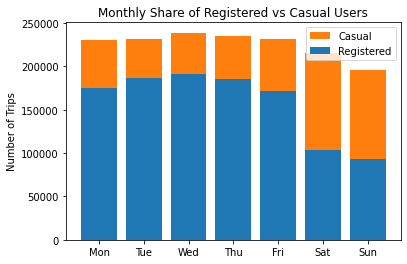

In [226]:
plotUserDataPerWeekDay(master_df, 'use_cnt', 'Number of Trips')

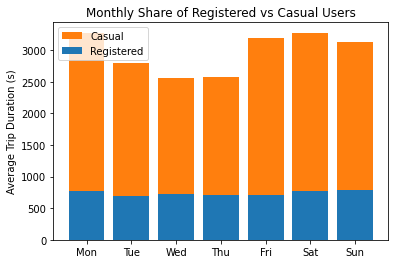

In [227]:
plotUserDataPerWeekDay(master_df, 'duration_avg', 'Average Trip Duration (s)')

In [599]:
def plotHistDistDuration(master_df, municipality):
    plt.hist(master_df[(master_df['municipal_start']==municipality) & (master_df['subsc_type'] == 'Registered') ]['duration'],range = (0, 3000), bins = 20, alpha = 0.5)
    plt.hist(master_df[(master_df['municipal_start']==municipality) & (master_df['subsc_type'] == 'Casual') ]['duration'],range = (0, 3000), bins = 20, alpha = 0.5)
    plt.title('Frequency Distribution of Trip Duration for ' + municipality)
    plt.xlabel('Duration (s)')
    plt.ylabel('Number of Trips')
    
    labels = ["Registered", "Casual"]
    plt.legend(labels)
    plt.show()

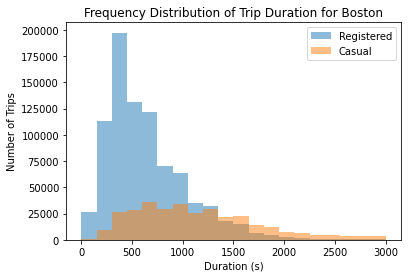

In [600]:
plotHistDistDuration(master_df, 'Boston')

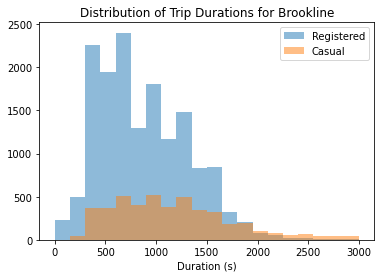

In [213]:
plotHistDuration('Brookline')

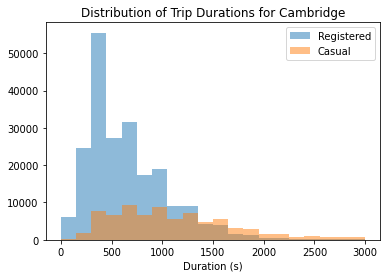

In [214]:
plotHistDuration('Cambridge')

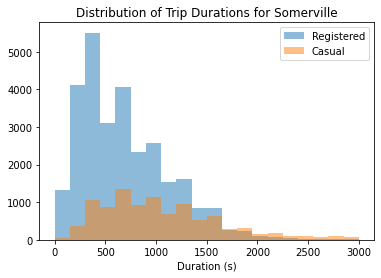

In [215]:
plotHistDuration('Somerville')

In [451]:
most_used_stations = master_df[['strt_statn', 'lat_start', 'lng_start', 'seq_id']].groupby(by=['strt_statn', 'lat_start', 'lng_start']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index()
   

In [591]:
def plotSpatialDataAllStations(master_df, hubway_stations_df):
    city_map = plt.imread('boston_map.png')
    BBox = ((hubway_stations_df.lng.min(), hubway_stations_df.lng.max(), hubway_stations_df.lat.min(), hubway_stations_df.lat.max()))
    most_used_stations = master_df[['strt_statn', 'lat_start', 'lng_start', 'seq_id']].groupby(by=['strt_statn', 'lat_start', 'lng_start']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(10)
    least_used_stations = master_df[['strt_statn', 'lat_start', 'lng_start', 'seq_id']].groupby(by=['strt_statn', 'lat_start', 'lng_start']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (True)).reset_index().head(10)
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(hubway_stations_df.lng, hubway_stations_df.lat, zorder=1, alpha= 1.0, c='b', s=30)
    ax.scatter(most_used_stations.lng_start, most_used_stations.lat_start, zorder=1, alpha= 1.0, c='g', s=30)
    ax.scatter(least_used_stations.lng_start, least_used_stations.lat_start, zorder=1, alpha= 1.0, c='r', s=30)
    ax.set_title('Boston City Spatial Data with Bike Stations')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    labels = ["Regular", "Most Used", "Least Used"]
    plt.legend(labels)

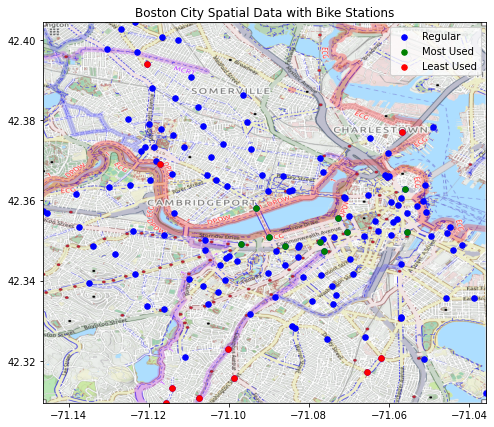

In [592]:
plotSpatialDataAllStations(master_df)

In [461]:
def plotSpatialDataStationInteractions(master_df):
    
    city_map = plt.imread('boston_map.png')
    BBox = ((hubway_stations_df.lng.min(), hubway_stations_df.lng.max(), hubway_stations_df.lat.min(), hubway_stations_df.lat.max()))
    stat_interactions = master_df[['strt_statn', 'end_statn', 'lat_start', 'lng_start', 'lat_end', 'lng_end', 'seq_id', 'duration']].groupby(by=['strt_statn', 'end_statn','lat_start', 'lng_start', 'lat_end', 'lng_end']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(30)
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(stat_interactions.lng_start, stat_interactions.lat_start, zorder=1, alpha= 0.3, c='b', s=100)
    ax.scatter(stat_interactions.lng_end, stat_interactions.lat_end, zorder=1, alpha= 0.3, c='b', s=100)
    
    ax.set_title('Boston City Spatial Data with Bike Stations')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    #labels = ["Regular"]
    X_coords = [stat_interactions.lng_start, stat_interactions.lng_end]
    Y_coords = [stat_interactions.lat_start, stat_interactions.lat_end]
    plt.plot(X_coords, Y_coords, color='red')

    #plt.legend(labels)
    plt.show()

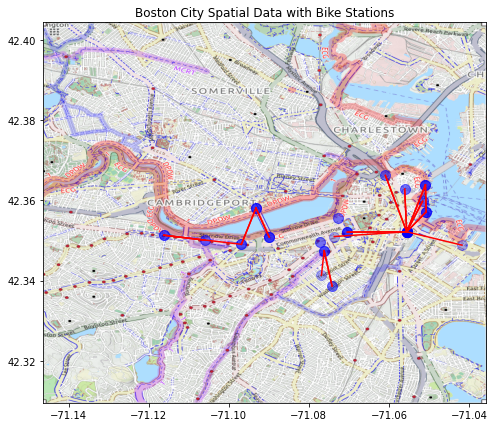

In [462]:
plotSpatialDataStationInteractions(master_df)

In [354]:
def plotUserDataPerWeatherEvent(master_df, variable, label):
        month_use_counts = master_df[['Events', 'subsc_type', 'seq_id', 'duration']].groupby(by=['Events', 'subsc_type']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values(['Events', 'subsc_type'], ascending=(True, True))
        labels = ['Rain&Snow', 'Clear', 'Rain', 'Snow']
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered')][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Casual')][variable]
        
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Registered')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Casual')

        ax.set_ylabel(label)
        ax.set_title('Monthly Share of Registered vs Casual Users')
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

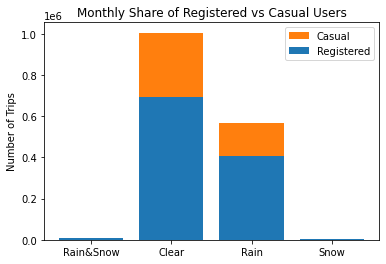

In [383]:
plotUserDataPerWeatherEvent(master_df, 'use_cnt', 'Number of Trips')

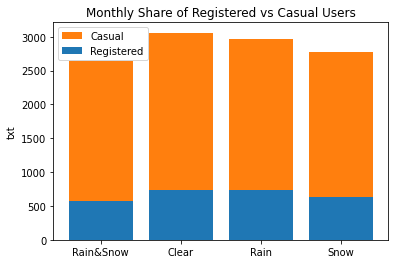

In [356]:
plotUserDataPerWeatherEvent(master_df, 'duration_avg', 'Average Trip Duration (s))

In [357]:
weather_boston.dtypes

Year                           int64
Month                          int64
Day                            int64
High Temp (F)                  int64
Avg Temp (F)                   int64
Low Temp (F)                   int64
High Dew Point (F)             int64
Avg Dew Point (F)              int64
Low Dew Point (F)              int64
High Humidity (%)              int64
Avg Humidity (%)               int64
Low Humidity (%)               int64
High Sea Level Press (in)    float64
Avg Sea Level Press (in)     float64
Low Sea Level Press (in)     float64
High Visibility (mi)           int64
Avg Visibility (mi)            int64
Low Visibility (mi)            int64
High Wind (mph)                int64
Avg Wind (mph)                 int64
High Wind Gust (mph)           int64
Snowfall (in)                float64
Precip (in)                  float64
Events                        object
dtype: object

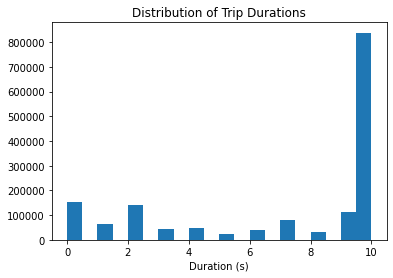

In [367]:
# Plot the histogram of trip durations for each city
plt.hist(master_df['Low Visibility (mi)'],range = (0, 10), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [589]:
bins = [0, 2, 4, 6, 8, np.inf]
names = ['0-2', '2-4', '4-6','6-8', '8+']
master_df['Avg VisibilityRange (mi)'] = pd.cut(master_df['Avg Visibility (mi)'], bins, labels=names)

In [490]:
def plotUserTypeStackData(master_df, title, group_var, variable, labels, label_x, label_y):        
        month_use_counts = master_df[[group_var, 'subsc_type', 'seq_id', 'duration']].groupby(by=[group_var, 'subsc_type']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values([group_var, 'subsc_type'], ascending=(True, True))
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered')][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Casual')][variable]
        
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Registered')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Casual')

        ax.set_ylabel(label_y)
        ax.set_xlabel(label_x)
        ax.set_title(title)
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

In [491]:
plotUserTypeStackData(master_df,
                                 'Effect of Visibility on User Behaviour',
                                 'duration_avg',
                                 ['0-2', '2-4', '4-6','6-8', '8+'],
                                 'Visibility Range (mi)',
                                 'Average Trip Duration (s)')

TypeError: plotUserTypeStackData() missing 1 required positional argument: 'label_y'

In [492]:
plotUserTypeStackData(master_df, 'use_cnt', 'Number of Trips')

TypeError: plotUserTypeStackData() missing 4 required positional arguments: 'variable', 'labels', 'label_x', and 'label_y'

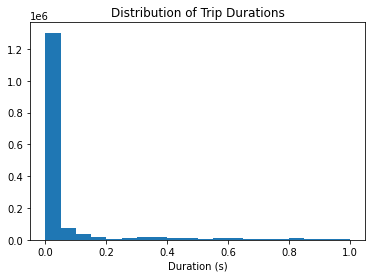

In [403]:

# Plot the histogram of trip durations for each city
plt.hist(master_df['Precip (in)'],range = (0, 1), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [405]:
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

In [605]:
def plotHistDistVar(master_df, title, xlabel, ylabel, var, start, end, bins_cnt):
    plt.hist(master_df[var],range = (start, end), bins = bins_cnt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

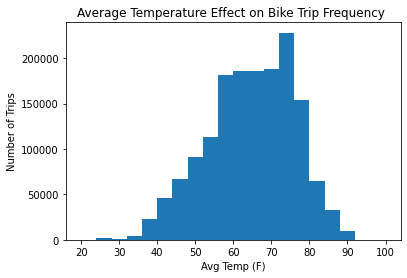

In [606]:
plotHistDistVar(master_df, 'Average Temperature Effect on Bike Trip Frequency ', 'Avg Temp (F)', 'Number of Trips', 'Avg Temp (F)', 20, 100, 20)

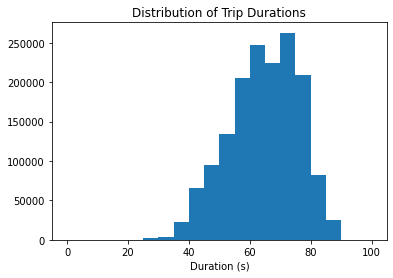

In [408]:
# Plot the histogram of trip durations for each city
plt.hist(master_df['Avg Temp (F)'],range = (0, 100), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [423]:
bins = [20, 40, 60, 80, np.inf]
names = ['20-40', '40-60', '60-80','80+']
master_df['Avg Temp Range (F)'] = pd.cut(master_df['Avg Temp (F)'], bins, labels=names)

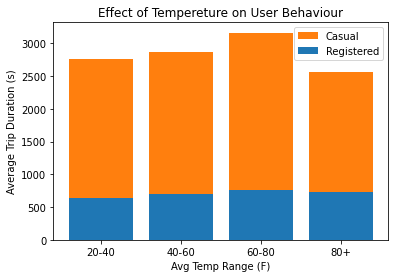

In [493]:
plotUserTypeStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Avg Temp Range (F) (mi)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Average Trip Duration (s)')

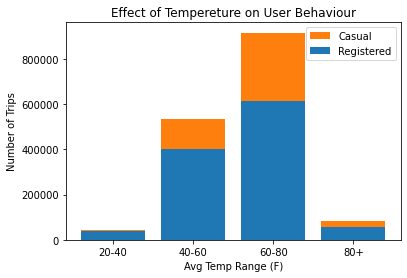

In [614]:
plotUserTypeStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Avg Temp Range (F) (mi)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Number of Trips')

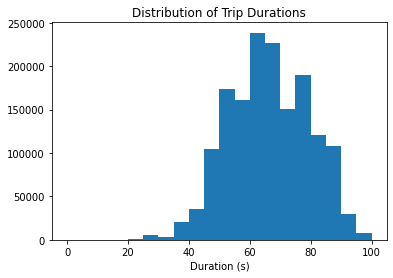

In [422]:

# Plot the histogram of trip durations for each city
plt.hist(master_df['Avg Humidity (%)'],range = (0, 100), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()


In [428]:
bins = [20, 40, 60, 80, np.inf]
names = ['20-40', '40-60', '60-80','80+']
master_df['Avg Humidity Range (%)'] = pd.cut(master_df['Avg Humidity (%)'], bins, labels=names)

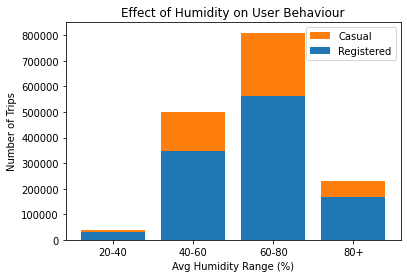

In [495]:
plotUserTypeStackData(master_df,
                                 'Effect of Humidity on User Behaviour',
                                 'Avg Humidity Range (%)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Number of Trips')

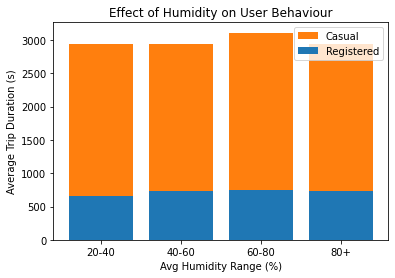

In [496]:
plotUserTypeStackData(master_df,
                                 'Effect of Humidity on User Behaviour',
                                 'Avg Humidity Range (%)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Humidity Range (%)',
                                 'Average Trip Duration (s)')

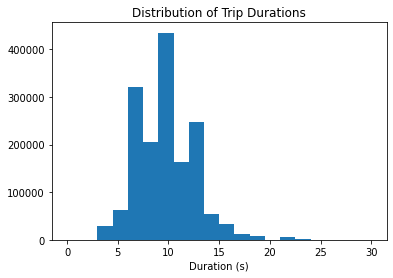

In [432]:


# Plot the histogram of trip durations for each city
plt.hist(master_df['Avg Wind (mph)'],range = (0, 30), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [433]:
bins = [0, 5, 10, 15, np.inf]
names = ['0-5', '5-10', '10-15','15+']
master_df['Avg Wind Range (mph)'] = pd.cut(master_df['Avg Wind (mph)'], bins, labels=names)

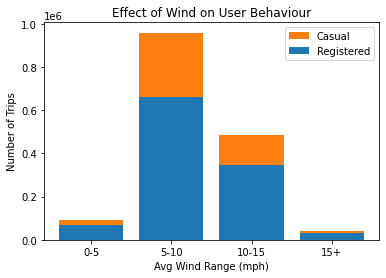

In [497]:
plotUserTypeStackData(master_df,
                                 'Effect of Wind on User Behaviour',
                                 'Avg Wind Range (mph)',
                                 'use_cnt',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Number of Trips')

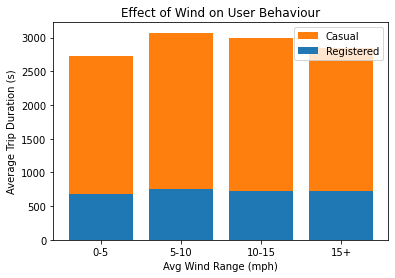

In [498]:
plotUserTypeStackData(master_df,
                                 'Effect of Wind on User Behaviour',
                                 'Avg Wind Range (mph)',
                                 'duration_avg',
                                 ['0-5', '5-10', '10-15','15+'],
                                 'Avg Wind Range (mph)',
                                 'Average Trip Duration (s)')

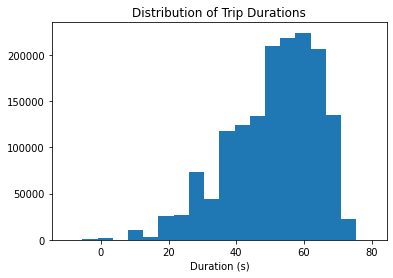

In [446]:

# Plot the histogram of trip durations for each city
plt.hist(master_df['Avg Dew Point (F)'],range = (-10, 80), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [447]:
bins = [-10, 20, 40, 60, np.inf]
names = ['-10-20', '20-40', '40-60','60+']
master_df['Avg Dew Point Range (F)'] = pd.cut(master_df['Avg Dew Point (F)'], bins, labels=names)

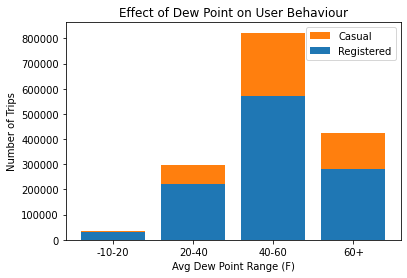

In [499]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Avg Dew Point Range (F)',
                                 'use_cnt',
                                 ['-10-20', '20-40', '40-60','60+'],
                                 'Avg Dew Point Range (F)',
                                 'Number of Trips')

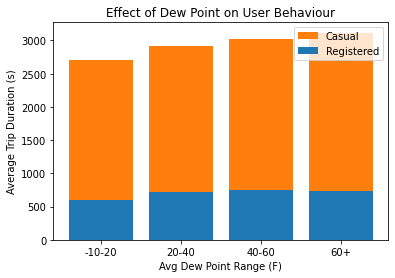

In [500]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Avg Dew Point Range (F)',
                                 'duration_avg',
                                 ['-10-20', '20-40', '40-60','60+'],
                                 'Avg Dew Point Range (F)',
                                 'Average Trip Duration (s)')

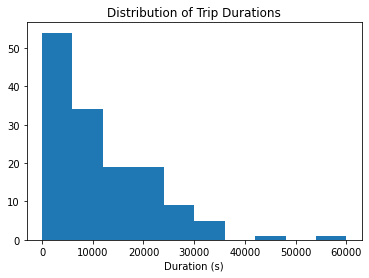

In [457]:

# Plot the histogram of trip durations for each city
plt.hist(most_used_stations['use_cnt'],range = (0,60000), bins = 10)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()


In [456]:
most_used_stations

,strt_statn,lat_start,lng_start,use_cnt
0,22.0,42.352175,-71.055547,56443
1,36.0,42.349673,-71.077303,42571
2,53.0,42.350851,-71.089886,35440
3,67.0,42.358100,-71.093198,33685
4,16.0,42.347433,-71.076163,32860
...,...,...,...,...
137,145.0,42.394002,-71.120406,221
138,125.0,42.322913,-71.100164,202
139,123.0,42.315692,-71.098634,161
140,108.0,42.320561,-71.061980,92


In [501]:
def plotUserGenderStackData(master_df, title, group_var, variable, labels, label_x, label_y):        
        month_use_counts = master_df[[group_var, 'subsc_type', 'gender', 'seq_id', 'duration']].groupby(by=[group_var, 'subsc_type', 'gender']).agg(use_cnt=('seq_id', 'count'), duration_avg=('duration', 'mean')).reset_index().sort_values([group_var, 'gender'], ascending=(True, True))
        reg_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered') & (month_use_counts['gender']=='Male') ][variable]
        cas_pct = month_use_counts[(month_use_counts['subsc_type']=='Registered') & (month_use_counts['gender']=='Female') ][variable]
        
        width = 0.8 # the width of the bars: can also be len(x) sequence

        fig, ax = plt.subplots()

        ax.bar(labels, reg_pct, width, label='Male')
        ax.bar(labels, cas_pct, width, bottom=reg_pct,
               label='Female')

        ax.set_ylabel(label_y)
        ax.set_xlabel(label_x)
        ax.set_title(title)
        ax.legend()
        
        # Matplotlib idiom to reverse legend entries 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))


        plt.show()

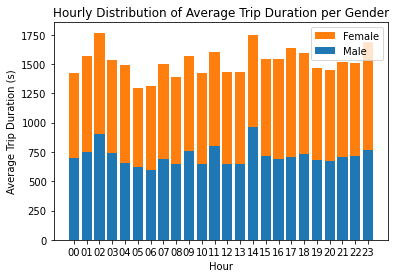

In [509]:
plotUserGenderStackData(master_df,
                                 'Hourly Distribution of Average Trip Duration per Gender',
                                 'hour_start',
                                 'duration_avg',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Average Trip Duration (s)')

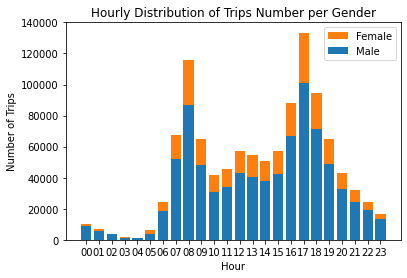

In [508]:
plotUserGenderStackData(master_df,
                                 'Hourly Distribution of Trips Number per Gender',
                                 'hour_start',
                                 'use_cnt',
                                 ['00', '01', '02','03', '04', '05', '06','07', '08', '09', '10','11', '12', '13', '14','15', '16', '17', '18','19', '20', '21', '22','23'],
                                 'Hour',
                                 'Number of Trips')

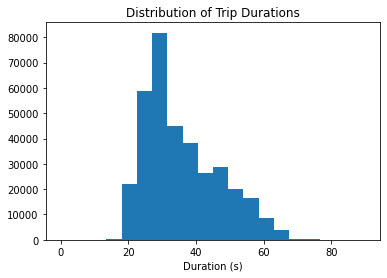

In [479]:
# Plot the histogram of trip durations for each city
plt.hist(master_df[(master_df['subsc_type']=='Registered') ]['age'],range = (0,90), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [480]:
bins = [0, 20, 40, 60, np.inf]
names = ['0-20', '20-40', '40-60','60+']
master_df['Age Range'] = pd.cut(master_df[(master_df['subsc_type']=='Registered') ]['age'], bins, labels=names)

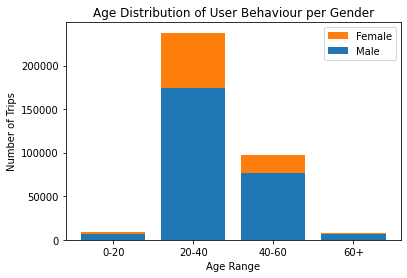

In [504]:
plotUserGenderStackData(master_df,
                                 'Age Distribution of User Behaviour per Gender',
                                 'Age Range',
                                 'use_cnt',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Number of Trips')

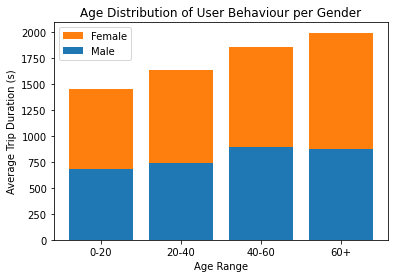

In [505]:
plotUserGenderStackData(master_df,
                                 'Age Distribution of User Behaviour per Gender',
                                 'Age Range',
                                 'duration_avg',
                                 ['0-20', '20-40', '40-60','60+'],
                                 'Age Range',
                                 'Average Trip Duration (s)')

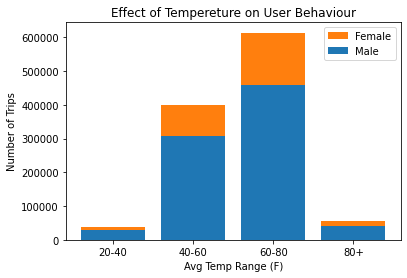

In [506]:
plotUserGenderStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Avg Temp Range (F) (mi)',
                                 'use_cnt',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Number of Trips')

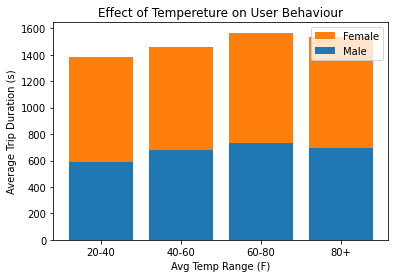

In [507]:
plotUserGenderStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Avg Temp Range (F) (mi)',
                                 'duration_avg',
                                 ['20-40', '40-60', '60-80','80+'],
                                 'Avg Temp Range (F)',
                                 'Average Trip Duration (s)')

In [541]:
zipcode_interactions

,zip_code,id_start,lat_start,lng_start,zip_code_lat,zip_code_lng,use_cnt
0,'02118,39.0,42.338623,-71.074182,42.3407,-71.0708,13295
1,'02118,25.0,42.341332,-71.076847,42.3407,-71.0708,12214
2,'02118,26.0,42.341522,-71.068922,42.3407,-71.0708,10498
3,'02118,57.0,42.340799,-71.081572,42.3407,-71.0708,10486


In [536]:
zipcode_interactions2 = master_df[['zip_code', 'seq_id']].groupby(by=['zip_code']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(10)


In [537]:
zipcode_interactions2

,zip_code,use_cnt
0,'02118,121749
1,'02139,89437
2,'02215,86758
3,'02116,77279
4,'02115,57522
5,'02138,39488
6,'02114,38307
7,'02143,36594
8,'02113,34376
9,'02134,28715


In [518]:
dict = {'zip_code': ["'02118", "'02139", "'02215", "'02116", "'02115", "'02138", "'02114", "'02143", "'02113", "'02134" ], 
        'zip_code_lat': [42.3407, 42.3643, 42.3476, 42.3514, 42.3480, 42.34733, 42.36033, 42.38371, 42.36285, 42.35595 ],
        'zip_code_lng': [-71.0708, -71.1022, -71.1009, -71.0776, -71.0885, -71.16867, -71.06732, -71.10213, -71.05518, -71.13411  ]
        
        
       }
zip_code_location = pd.DataFrame(data=dict)

In [519]:
zip_code_location

,zip_code,zip_code_lat,zip_code_lng
0,'02118,42.34070,-71.07080
1,'02139,42.36430,-71.10220
2,'02215,42.34760,-71.10090
3,'02116,42.35140,-71.07760
4,'02115,42.34800,-71.08850
5,'02138,42.34733,-71.16867
6,'02114,42.36033,-71.06732
7,'02143,42.38371,-71.10213
8,'02113,42.36285,-71.05518
9,'02134,42.35595,-71.13411


In [542]:
def plotSpatialDataStations2(zip_code_location):
    city_map = plt.imread('boston_map.png')
    BBox = ((zip_code_location.zip_code_lng.min(), zip_code_location.zip_code_lng.max(), zip_code_location.zip_code_lat.min(), zip_code_location.zip_code_lat.max()))
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(zip_code_location.zip_code_lng, zip_code_location.zip_code_lat, zorder=1, alpha= 1.0, c='b', s=30)
    ax.set_title('Approximate User Locations With Highest Frequency of Use')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    labels = ["User Residence Location"]
    plt.legend(labels)

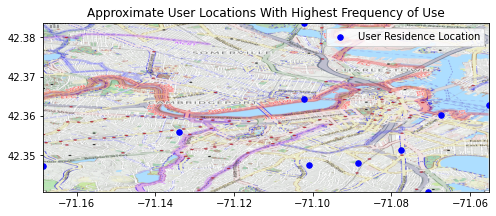

In [543]:
plotSpatialDataStations2(zip_code_location)

In [533]:
master_df = pd.merge(master_df, zip_code_location, how='left', left_on=['zip_code'], right_on=['zip_code'])

In [544]:
zipcode_interactions = master_df[['zip_code', 'id_start', 'lat_start', 'lng_start', 'zip_code_lat', 'zip_code_lng', 'seq_id']].groupby(by=['zip_code', 'id_start', 'lat_start', 'lng_start', 'zip_code_lat', 'zip_code_lng']).agg(use_cnt=('seq_id', 'count')).sort_values(["use_cnt"], ascending = (False)).reset_index().head(4)

In [545]:
zipcode_interactions

,zip_code,id_start,lat_start,lng_start,zip_code_lat,zip_code_lng,use_cnt
0,'02118,39.0,42.338623,-71.074182,42.3407,-71.0708,13295
1,'02118,25.0,42.341332,-71.076847,42.3407,-71.0708,12214
2,'02118,26.0,42.341522,-71.068922,42.3407,-71.0708,10498
3,'02118,57.0,42.340799,-71.081572,42.3407,-71.0708,10486


In [548]:
def plotSpatialDataStationInteractions2(zipcode_interactions):
    
    city_map = plt.imread('boston_map.png')
    BBox = ((zipcode_interactions.lng_start.min(), zipcode_interactions.lng_start.max(), zipcode_interactions.lat_start.min(), zipcode_interactions.lat_start.max()))
    fig, ax = plt.subplots(figsize = (8,7))
    ax.scatter(zipcode_interactions.zip_code_lng, zipcode_interactions.zip_code_lat, zorder=1, alpha= 0.3, c='b', s=100)
    ax.scatter(zipcode_interactions.lng_start, zipcode_interactions.lat_start, zorder=1, alpha= 0.3, c='b', s=100)
    
    ax.set_title('Boston City Spatial Data with Bike Stations')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(city_map, zorder=0, extent = BBox, aspect= 'equal')
    #labels = ["Regular"]
    X_coords = [zipcode_interactions.zip_code_lng, zipcode_interactions.lng_start]
    Y_coords = [zipcode_interactions.zip_code_lat, zipcode_interactions.lat_start]
    plt.plot(X_coords, Y_coords, color='red')

    #plt.legend(labels)
    plt.show()

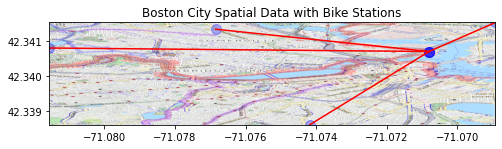

In [549]:
plotSpatialDataStationInteractions2(zipcode_interactions)

In [611]:
bike_agg = master_df[['bike_nr', 'seq_id', 'duration']].groupby(by=['bike_nr']).agg(bike_use_cnt=('seq_id', 'count'), bike_ride_duration_avg=('duration', 'mean')).sort_values(["bike_use_cnt"], ascending = (False)).reset_index()

In [612]:
len(bike_agg)

1163

In [613]:
bike_agg

,bike_nr,bike_use_cnt,bike_ride_duration_avg
0,B00490,2138,1153.217493
1,B00268,2124,1428.444444
2,B00548,2112,1116.574811
3,B00559,2091,1046.934959
4,B00563,2080,1084.037500
...,...,...,...
1158,T01129,49,680.142857
1159,B00218,35,197444.200000
1160,B00137,31,346005.419355
1161,B00542,28,366285.928571


In [569]:
master_df = pd.merge(master_df, bike_agg, how='left', left_on=['bike_nr'], right_on=['bike_nr'])

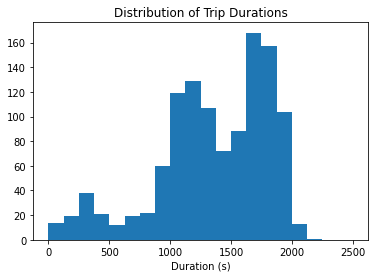

In [572]:
plt.hist(bike_agg['bike_use_cnt'],range = (0, 2500), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [609]:
bins = [0, 500, 1000, 1500, np.inf]
names = ['0-500', '500-1000', '1000-1500','1500+']
master_df['Bike Use Range'] = pd.cut(master_df['bike_use_cnt'], bins, labels=names)

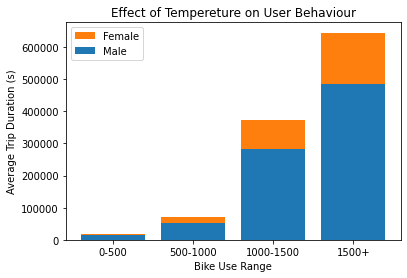

In [610]:
plotUserGenderStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Bike Use Range',
                                 'use_cnt',
                                 ['0-500', '500-1000', '1000-1500','1500+'],
                                 'Bike Use Range',
                                 'Average Trip Duration (s)')

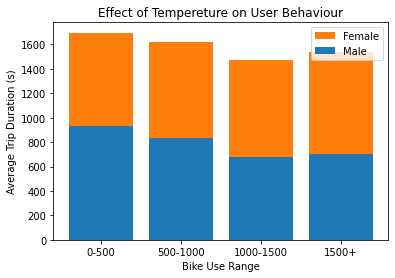

In [576]:
plotUserGenderStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Bike Use Range',
                                 'duration_avg',
                                 ['0-500', '500-1000', '1000-1500','1500+'],
                                 'Bike Use Range',
                                 'Average Trip Duration (s)')

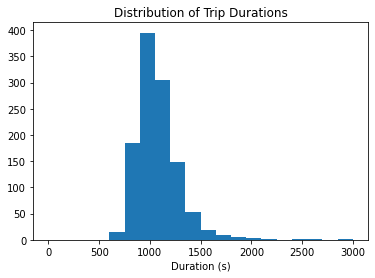

In [580]:
plt.hist(bike_agg['bike_ride_duration_avg'],range = (0, 3000), bins = 20)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (s)')
plt.show()

In [581]:
bins = [500, 1000, 1500, np.inf]
names = ['500-1000', '1000-1500','1500+']
master_df['Bike Avg Time Use Range'] = pd.cut(master_df['bike_ride_duration_avg'], bins, labels=names)

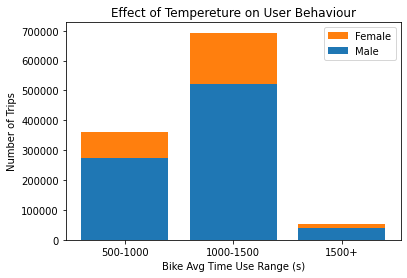

In [583]:
plotUserGenderStackData(master_df,
                                 'Effect of Tempereture on User Behaviour',
                                 'Bike Avg Time Use Range',
                                 'use_cnt',
                                 ['500-1000', '1000-1500','1500+'],
                                 'Bike Avg Time Use Range (s)',
                                 'Number of Trips')

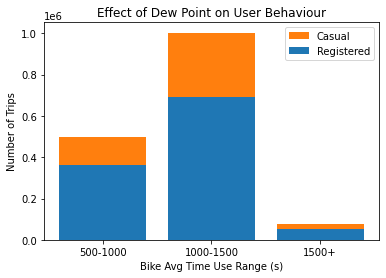

In [585]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Bike Avg Time Use Range',
                                 'use_cnt',
                                 ['500-1000', '1000-1500','1500+'],
                                 'Bike Avg Time Use Range (s)',
                                 'Number of Trips')

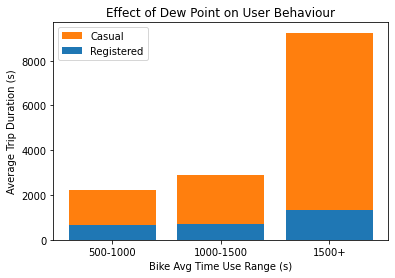

In [586]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Bike Avg Time Use Range',
                                 'duration_avg',
                                 ['500-1000', '1000-1500','1500+'],
                                 'Bike Avg Time Use Range (s)',
                                 'Average Trip Duration (s)')

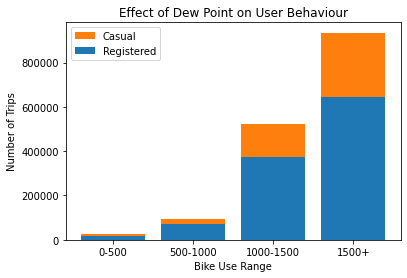

In [587]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Bike Use Range',
                                 'use_cnt',
                                 ['0-500', '500-1000', '1000-1500','1500+'],
                                 'Bike Use Range',
                                 'Number of Trips')

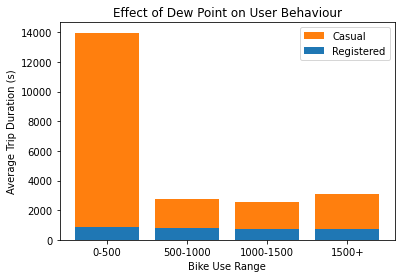

In [588]:
plotUserTypeStackData(master_df,
                                 'Effect of Dew Point on User Behaviour',
                                 'Bike Use Range',
                                 'duration_avg',
                                 ['0-500', '500-1000', '1000-1500','1500+'],
                                 'Bike Use Range',
                                 'Average Trip Duration (s)')